In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label
from scipy.ndimage import distance_transform_edt, center_of_mass
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
import random


# DATA LOADING

In [18]:
def list_images_by_class(root, classes=("A","B","C","D"), exts={".png",".jpg",".jpeg",".bmp",".tif",".tiff"}):
    files = {c: [] for c in classes}
    for c in classes:
        class_dir = os.path.join(root, c)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if os.path.splitext(fname)[1].lower() in exts:
                files[c].append(os.path.join(class_dir, fname))
    return files

def read_gray(path):
    img = Image.open(path).convert("L")
    return np.array(img)

def ensure_binary(img_gray, invert_if_needed=True):
    g = img_gray
    if g.dtype != np.uint8:
        g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    thresh = threshold_otsu(g)
    bin_img = (g < thresh).astype(np.uint8) 
    if invert_if_needed:
        if bin_img.mean() > 0.5:
            bin_img = 1 - bin_img
    return bin_img, g


# FEATURES

In [ ]:
def compute_features(img_gray):

    bin_img, g = ensure_binary(img_gray)

    # Distance to background for foreground pixels:
    dt = distance_transform_edt(bin_img)

    skel = skeletonize(bin_img.astype(bool))
    skel_dt = dt[skel]
    if skel_dt.size > 0:
        # Stroke width ~ 2 * distance-to-edge at skeleton
        widths = 2.0 * skel_dt
        stroke_width_mean = float(np.mean(widths))
        stroke_width_std = float(np.std(widths))
    else:
        stroke_width_mean = 0.0
        stroke_width_std = 0.0

    return dict(
        stroke_width_mean=stroke_width_mean,
        stroke_width_std=stroke_width_std
    )


In [20]:
def compute_dataset_stats(files_by_class, max_per_class=None):
    stats = {c: [] for c in files_by_class}
    for c, files in files_by_class.items():
        use_files = files if max_per_class is None else files[:max_per_class]
        for f in tqdm(use_files, desc=f"Processing {c}"):
            g = read_gray(f)
            feats = compute_features(g)
            stats[c].append(feats)
    return stats

def summarize_stats(stats):
    per_class = {}
    all_feats = []
    for c, lst in stats.items():
        all_feats.extend(lst)
        if lst:
            per_class[c] = {
                "n": len(lst),
                "stroke_width_mean": float(np.mean([f["stroke_width_mean"] for f in lst])),
                "stroke_width_std": float(np.std([f["stroke_width_mean"] for f in lst])),
            }
        else:
            per_class[c] = None
    overall = None
    if all_feats:
        overall = {
            "n": len(all_feats),
            "stroke_width_mean": float(np.mean([f["stroke_width_mean"] for f in all_feats])),
            "stroke_width_std": float(np.std([f["stroke_width_mean"] for f in all_feats])),
        }
    return per_class, overall


In [21]:


def kde_compare(distrib1, distrib2, title, xlabel):
    plt.figure(figsize=(6,4))
    sns.kdeplot(distrib1, label='EHC Dataset', fill=True, alpha=0.4)
    sns.kdeplot(distrib2, label='Pen Path Dataset', fill=True, alpha=0.4)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()


Processing 9: 100%|██████████| 556/556 [00:02<00:00, 247.52it/s]


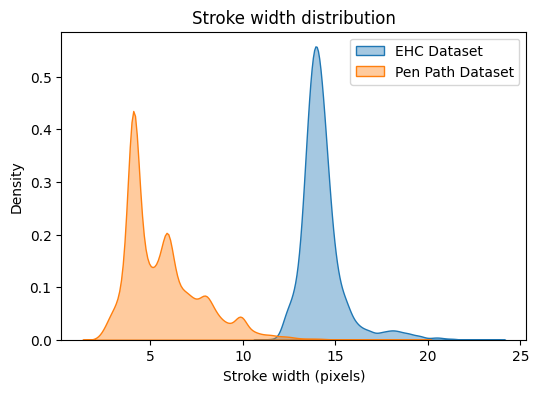

Class A summary:
- N: Kaggle 55, Human 554
- Stroke width mean: Kaggle 14.24, Human 4.81
Class B summary:
- N: Kaggle 55, Human 546
- Stroke width mean: Kaggle 14.73, Human 5.16
Class C summary:
- N: Kaggle 55, Human 572
- Stroke width mean: Kaggle 14.29, Human 5.21
Class D summary:
- N: Kaggle 55, Human 549
- Stroke width mean: Kaggle 13.99, Human 5.25
Class E summary:
- N: Kaggle 55, Human 546
- Stroke width mean: Kaggle 14.82, Human 5.06
Class F summary:
- N: Kaggle 55, Human 547
- Stroke width mean: Kaggle 14.45, Human 4.96
Class G summary:
- N: Kaggle 55, Human 554
- Stroke width mean: Kaggle 14.42, Human 4.67
Class H summary:
- N: Kaggle 55, Human 552
- Stroke width mean: Kaggle 13.61, Human 4.76
Class I summary:
- N: Kaggle 55, Human 581
- Stroke width mean: Kaggle 13.59, Human 5.26
Class J summary:
- N: Kaggle 55, Human 551
- Stroke width mean: Kaggle 13.78, Human 4.90
Class K summary:
- N: Kaggle 55, Human 553
- Stroke width mean: Kaggle 14.16, Human 4.84
Class L summary:
- N:

In [23]:
kaggle_root = "z_AGAIN_kaggle_upscaled_inverted"
human_root  = "user_splits\\out_user_7MK_train"
classes = ("A","B","C","D", "E", "F", "G", "H", "I", "J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z",
           "lowercase_a","lowercase_b","lowercase_c","lowercase_d","lowercase_e","lowercase_f","lowercase_g","lowercase_h",
           "lowercase_i","lowercase_j","lowercase_k","lowercase_l","lowercase_m","lowercase_n","lowercase_o","lowercase_p",
           "lowercase_q","lowercase_r","lowercase_s","lowercase_t","lowercase_u","lowercase_v","lowercase_w","lowercase_x",
           "lowercase_y","lowercase_z","0","1","2","3","4","5","6","7","8","9",)

k_files = list_images_by_class(kaggle_root, classes)
h_files = list_images_by_class(human_root, classes)

k_stats = compute_dataset_stats(k_files, max_per_class=None)
h_stats = compute_dataset_stats(h_files, max_per_class=None)

k_per_class, k_overall = summarize_stats(k_stats)
h_per_class, h_overall = summarize_stats(h_stats)


def collect(lst, key):
    return [f[key] for f in lst]

k_all = sum(k_stats.values(), [])
h_all = sum(h_stats.values(), [])

if k_all and h_all:
    kde_compare(collect(k_all, "stroke_width_mean"), collect(h_all, "stroke_width_mean"),
                "Stroke width distribution", "Stroke width (pixels)")
    
for c in classes:
    if k_per_class.get(c) and h_per_class.get(c):
        print(f"Class {c} summary:")
        print(f"- N: Kaggle {k_per_class[c]['n']}, Human {h_per_class[c]['n']}")
        print(f"- Stroke width mean: Kaggle {k_per_class[c]['stroke_width_mean']:.2f}, Human {h_per_class[c]['stroke_width_mean']:.2f}")
